#  Initial Data Analysis: Corrosion Classification Dataset

This notebook performs an initial analysis of the corrosion classification dataset.  
There are two folders

- **corrosion**
- **no_corrosion**

We will analyze the distribution of the dataset and determine which samples are suitable for model training.


In [6]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import csv

## 1.  Counting Total Sample Folders

We begin by counting the number of folders in the dataset.  
Each folder represents one sample and may contain an RGB image and several masks.


In [7]:
corrosion_root = Path("/home/shared-data/corrosion_images/corrosion")
no_corrosion_root = Path("/home/shared-data/corrosion_images/no_corrosion")

num_corrosion_img = len(list(corrosion_root.rglob("*.jpg"))) + len(list(corrosion_root.rglob("*.png")))
num_no_corrosion_img = len(list(no_corrosion_root.rglob("*.jpg"))) + len(list(no_corrosion_root.rglob("*.png")))

print(f"Total samples of corrosion: {num_corrosion_img}")
print(f"\nTotal samples of no corrosion: {num_corrosion_img}")

Total samples of corrosion: 1992

Total samples of no corrosion: 1992


## 2. Checking out Image Sizes

How big are the images in each folder? 
In this part, we compute basic statistics: min, max, and mean of width and height.


In [8]:
def get_image_sizes(image_dir):
    sizes = []
    for img_path in image_dir.rglob("*.[jp][pn]g"):  # jpg or png
        with Image.open(img_path) as img:
            sizes.append(img.size)  # get width and height
    return np.array(sizes)

corrosion_sizes = get_image_sizes(corrosion_root)
no_corrosion_sizes = get_image_sizes(no_corrosion_root)

print("Corrosion images:"
"\nmin: ", corrosion_sizes.min(axis=0),
"\nmax: ",  corrosion_sizes.max(axis=0),
"\nmean sizes: ", corrosion_sizes.mean(axis=0))

print("\n\nNo corrosion images:"
"\nmin: ", no_corrosion_sizes.min(axis=0),
"\nmax: ",  no_corrosion_sizes.max(axis=0),
"\nmean sizes: ", no_corrosion_sizes.mean(axis=0))

Corrosion images:
min:  [360 480] 
max:  [7360 5984] 
mean sizes:  [2096.21636546 1598.50200803]


No corrosion images:
min:  [285 380] 
max:  [5984 5312] 
mean sizes:  [2353.80338477 1828.56495769]


## 3. Visualizing Examples

We now visualize a few examples to get an intuition about image quality and patterns

Random corrosion images:



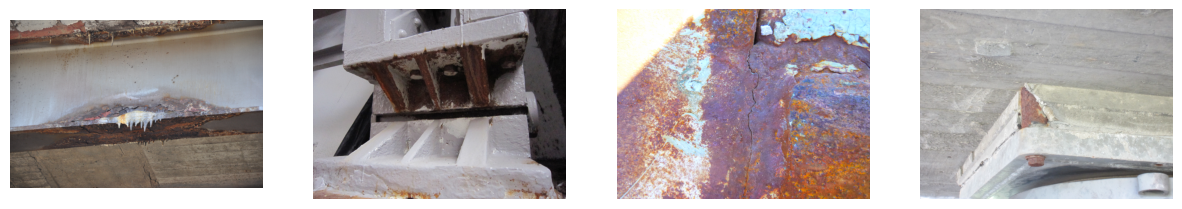


Random corrosion images:



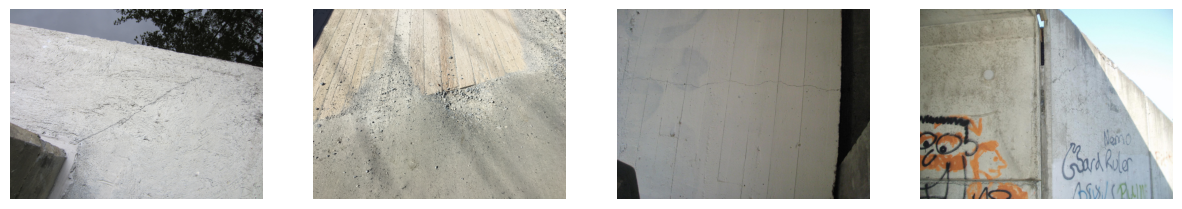

In [12]:
def show_random_images(image_dir, n=4):
    img_paths = list(image_dir.rglob("*.[jp][pn]g"))
    sample_paths = random.sample(img_paths, n)
    # print(sample_paths)
    fig, axs = plt.subplots(1, n, figsize=(15,5))
    for ax, path in zip(axs, sample_paths):
        img = Image.open(path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

print("Random corrosion images:\n")
show_random_images(corrosion_root)
print("\nRandom corrosion images:\n")
show_random_images(no_corrosion_root)

## 4. Finding Corrupted, all-white or all-black Images

Is all of the data usable?

In [13]:
dataset_root = Path("/home/shared-data/corrosion_images")

def check_images(image_dir):
    bad_images = []
    full_black = []
    full_white = []
    
    for img_path in image_dir.rglob("*.[jp][pn]g"):  # jpg or png
        try:
            with Image.open(img_path) as img:
                img_array = np.array(img)
                
                # Check if image is completely black
                if img_array.max() == 0:
                    full_black.append(img_path)
                # Check if image is completely white
                elif img_array.min() == 255:
                    full_white.append(img_path)
                
        except Exception as e:
            bad_images.append((img_path, str(e)))  # image cannot be opened
    
    return bad_images, full_black, full_white

corrupt, black, white = check_images(dataset_root)
print("Corrupted images:", corrupt)
print("Completely black images:", black)
print("Completely white images:", white)

Corrupted images: [(PosixPath('/home/shared-data/corrosion_images/corrosion/8943780.jpg'), 'image file is truncated (19 bytes not processed)'), (PosixPath('/home/shared-data/corrosion_images/corrosion/6027309.jpg'), 'image file is truncated (17 bytes not processed)')]
Completely black images: []
Completely white images: []


There are only 2 corrupted images. "8943780" and "6027309" in the corrosion folder. In order for them not to casue issues when training, we should not include them further. For that, we create a CSV file with the image path and label (corrosion or no_corrosion).

In [14]:
dataset_root = Path("/home/shared-data/corrosion_images")

# known corrupted images from above taken
corrupt_images = [
    corrosion_root / "8943780.jpg",
    corrosion_root / "6027309.jpg"
]

# function to get list of valid image path names
def list_images(image_dir, exclude=[]):
    exclude_names = [p.name for p in exclude]  # just filenames
    images = []
    for img_path in image_dir.rglob("*.[jp][pn]g"):  # jpg or png
        if img_path.name not in exclude_names:
            rel_path = img_path.relative_to(dataset_root)
            images.append(str(rel_path))
    return images

# save images path names in variables
corrosion_images = list_images(corrosion_root, exclude=corrupt_images)
no_corrosion_images = list_images(no_corrosion_root)

print(f"Valid corrosion images: {len(corrosion_images)}")
print(f"Valid no-corrosion images: {len(no_corrosion_images)}")

# initialize csv file
csv_file = "corrosion_dataset.csv"

with open(csv_file, "w", newline="") as f:
    # CSV header
    writer = csv.writer(f)
    writer.writerow(["filename", "label"])
    
    # corrosion images
    for img in corrosion_images:
        writer.writerow([img, "corrosion"])
    
    # no-corrosion images
    for img in no_corrosion_images:
        writer.writerow([img, "no_corrosion"])

Valid corrosion images: 1990
Valid no-corrosion images: 2009


The csv "corrosion_dataset.csv" has all of the images with the label